In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
import xgboost as xgb
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [99]:
data = pd.read_csv('data_preprocessed/data_3511.csv', index_col='Unnamed: 0') #drop(columns=['RedFighter', 'BlueFighter', 'Result'], axis=1)
# y = pd.read_csv('ufc-master-for-binary-classification.csv', index_col='Unnamed: 0')['Result']

In [100]:
# data = data.loc[:2200, :]
X = data.drop(['Result'], axis=1)
y = data['Result']

In [101]:
# X = X.iloc[:1500, :]
# y = y.iloc[:1500]


test_size = int(len(X)*0.15)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y)

In [82]:
y_train =np.array(y_train)
y_test =np.array(y_test)

In [102]:
# Масштабируйте данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### XGBoost

In [103]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    max_depth = trial.suggest_int('max_depth', 1, 16)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    gamma = trial.suggest_loguniform('gamma', 0.01, 10.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.2, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 10.0)

    # Создание модели
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, gamma=gamma,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Оценка модели
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=200)

# Вывод лучших гиперпараметров и результата
# print("Лучшие гиперпараметры:", study.best_params)
# print("Результат:", study.best_value)

# Создание модели с лучшими гиперпараметрами
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train_scaled, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_model.predict(X_test_scaled)
print("F1-мера модели с лучшими гиперпараметрами:", f1_score(y_test, y_pred, average='weighted'))
# Вывод параметров лучшей модели
print("Параметры лучшей модели:", best_model.get_params())

[I 2025-01-17 22:54:26,330] A new study created in memory with name: no-name-5a2e3ebf-d7c3-484e-b8c5-66086c366906
[I 2025-01-17 22:54:26,412] Trial 0 finished with value: 0.4350132625994695 and parameters: {'max_depth': 11, 'learning_rate': 0.11818154122863415, 'n_estimators': 8, 'gamma': 0.21536296849739553, 'subsample': 0.941308694325089, 'colsample_bytree': 0.8089566673661768, 'reg_alpha': 0.055645441971860436, 'reg_lambda': 0.6136347396720171}. Best is trial 0 with value: 0.4350132625994695.
[I 2025-01-17 22:54:26,856] Trial 1 finished with value: 0.49065420560747663 and parameters: {'max_depth': 12, 'learning_rate': 0.2147670997572902, 'n_estimators': 82, 'gamma': 0.05211600015547408, 'subsample': 0.8799207052792413, 'colsample_bytree': 0.53894659624627, 'reg_alpha': 0.15084634064118546, 'reg_lambda': 1.6121474201799335}. Best is trial 1 with value: 0.49065420560747663.
[I 2025-01-17 22:54:27,047] Trial 2 finished with value: 0.5 and parameters: {'max_depth': 10, 'learning_rate': 

F1-мера модели с лучшими гиперпараметрами: 0.6547344349529668
Параметры лучшей модели: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8632638215127677, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.015634961635605717, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.42028312036482746, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 14, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 96, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 4.0968292575636305, 'reg_lambda': 5.1179743115602605, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9791596483226537,

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       287
           1       0.65      0.54      0.59       239

    accuracy                           0.66       526
   macro avg       0.66      0.65      0.65       526
weighted avg       0.66      0.66      0.65       526



Text(0.5, 23.52222222222222, 'predicted value')

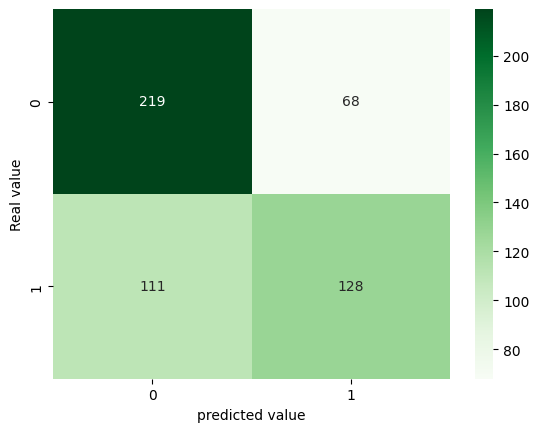

In [104]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### PyTorch

In [62]:
y_train =np.array(y_train)
y_test =np.array(y_test)

In [63]:
# # Стандартизация данных
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
    
# Параметры модели
input_size = X_train_scaled.shape[1]
hidden_size = 128
num_classes = 2
learning_rate = 0.01
num_epochs = 10
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(model.parameters(), lr=learning_rate)

In [64]:
# Обучение модели
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/10], Loss: 0.6581


In [65]:
# Оценка модели
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score: {f1:.4f}')

Accuracy: 0.6667
F1 Score: 0.6584


In [51]:
# Функция для аугментации данных
def augment_data(X, y, noise_level=0.05):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise
    y_augmented = y.copy()
    return X_augmented, y_augmented

# Аугментация тренировочных данных
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented.values, dtype=torch.float32)
# y_train_augmented_tensor = torch.tensor(y_train_augmented.values, dtype=torch.long)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/10], Loss: 0.8375


In [52]:
# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after augmentation: {accuracy:.4f}')

    # Вычисление F1-меры
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after augmentation: {f1:.4f}')

Accuracy after augmentation: 0.6667
F1 Score after augmentation: 0.6653


Датасет + аугментированный датасет

In [55]:
# # Стандартизация данных
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 128
num_classes = 2
learning_rate = 0.03
num_epochs = 50
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader для базовых данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Функция для аугментации данных
def augment_data(X,noise_level=0.04):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise  
    return X_augmented

# Аугментация тренировочных данных
X_train_augmented = augment_data(X_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented, dtype=torch.float32)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(model.parameters(), lr=learning_rate)

# Обучение модели на базовых данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на базовых данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on base data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on base data: {f1:.4f}')

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on augmented data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on augmented data: {f1:.4f}')

ValueError: could not determine the shape of object type 'DataFrame'